In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

Feature Engineering

In [3]:
transaction_features = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "TransactionID": "count",
    "ProductID": "nunique"
}).rename(columns={"TransactionID": "TransactionCount", "ProductID": "UniqueProducts"})

Merging with customers

In [4]:
customers["Region"] = customers["Region"].astype("category").cat.codes
customers["SignupDays"] = (pd.to_datetime("2025-01-01") - pd.to_datetime(customers["SignupDate"])).dt.days
customer_data = customers.set_index("CustomerID").join(transaction_features)

In [5]:
customer_data.fillna(0, inplace=True)

In [7]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(customer_data.drop(columns=["CustomerName", "SignupDate"]))

Clustering

In [8]:
results = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)

    db_index = davies_bouldin_score(normalized_data, cluster_labels)
    results[k] = {"model": kmeans, "DBI": db_index, "labels": cluster_labels}

Best clustering result based on lowest DB Index

In [9]:
best_k = min(results, key=lambda k: results[k]["DBI"])
best_model = results[best_k]["model"]
customer_data["Cluster"] = results[best_k]["labels"]

print(f"Optimal number of clusters: {best_k}")
print(f"Davies-Bouldin Index for best clustering: {results[best_k]['DBI']}")

Optimal number of clusters: 10
Davies-Bouldin Index for best clustering: 1.104928070346451


Visualization of clusters

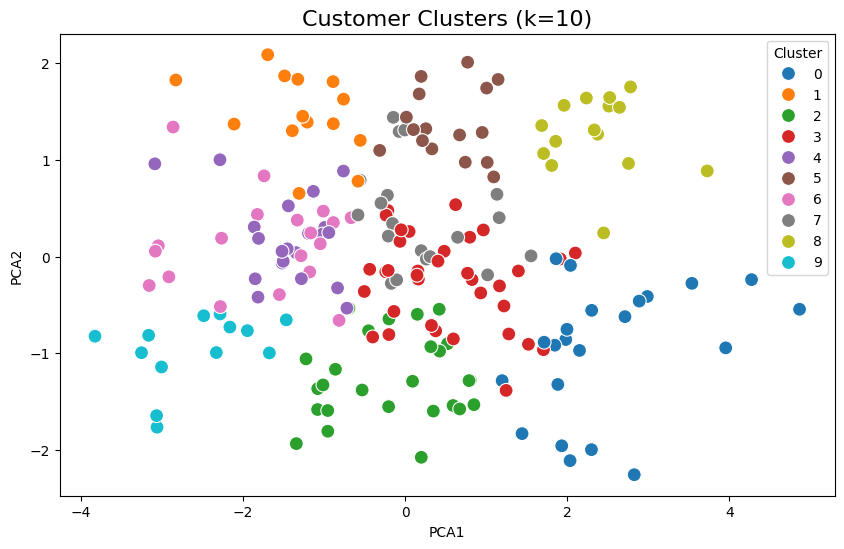

In [10]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)
customer_data["PCA1"], customer_data["PCA2"] = pca_data[:, 0], pca_data[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=customer_data, palette="tab10", s=100
)
plt.title(f"Customer Clusters (k={best_k})", fontsize=16)
plt.show()

In [11]:
cluster_sizes = customer_data["Cluster"].value_counts()
print(cluster_sizes)


Cluster
3    35
2    26
0    22
4    21
6    19
7    19
5    16
8    15
1    14
9    13
Name: count, dtype: int64


In [12]:
centroids = pd.DataFrame(best_model.cluster_centers_, columns=customer_data.columns.drop(["CustomerName", "SignupDate", "Cluster", "PCA1", "PCA2"]))
print(centroids)

     Region  SignupDays  TotalValue  TransactionCount  UniqueProducts
0 -0.887162   -0.152050    1.438708          1.538501        1.489806
1  0.925831    0.961946   -0.853252         -0.838117       -0.810312
2 -0.933501   -0.866777    0.047031         -0.069430       -0.047277
3  0.686011   -0.938817    0.155019          0.348141        0.409512
4 -0.862300    0.876448   -0.817019         -0.816627       -0.854994
5  1.241384    0.782748    0.416210          0.141029        0.119637
6  0.776359   -0.779518   -1.001758         -1.068853       -1.074877
7 -0.525710    1.072327    0.074658          0.095009        0.135070
8  1.005771    1.093549    1.182200          1.383967        1.280815
9 -1.137397   -0.586410   -1.228813         -1.527456       -1.526945
